# Genereative Adversarial Networks

The main goal of **Generative Adversarial Network** (GAN) is to generate images that are similar (but not identical) to training dataset.

GAN consists of two neural networks that are trained against each other:

 * **Generator** takes a random vector, and should generate an image from it
 * **Discriminator** is a networks that should distinguish between original image (from training dataset), and the one generated by the generator.

<img src="./images/gan_architecture.png" width="70%"/>

In [ ]:
# Import necessary libraries
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [ ]:
# Check if CUDA (GPU) is available, use 'cuda:0' if available, else use 'cpu'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Percentage of the dataset to use for training, set to 1.0 to use the entire dataset
train_size = 1.0

# Learning rate for the optimizer
lr = 2e-4

# Weight decay, a regularization term to prevent overfitting
weight_decay = 8e-9

# Beta1 parameter for the Adam optimizer (controls the exponential decay of the first moment estimate)
beta1 = 0.5

# Beta2 parameter for the Adam optimizer (controls the exponential decay of the second moment estimate)
beta2 = 0.999

# Batch size for training
batch_size = 256

# Number of epochs (complete passes through the entire training dataset)
epochs = 100

# Frequency of plotting or logging during training, e.g., plot every 10 epochs
plot_every = 10


## Generator

The role of a generator is to take a random vector of some size (it is similar to latent vector in autoencoders) and generate the target image. It is very similar to the generative side of autoencoder.

In our example, we will use linear neural networks and MNIST dataset.

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Fully connected layers with batch normalization and leaky ReLU activation
        self.linear1 = nn.Linear(100, 256)
        self.bn1 = nn.BatchNorm1d(256, momentum=0.2)
        self.leaky_relu = nn.LeakyReLU(0.2)

        self.linear2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512, momentum=0.2)

        self.linear3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024, momentum=0.2)

        # Output layer with Tanh activation to map values to the range [-1, 1]
        self.linear4 = nn.Linear(1024, 784)
        self.tanh = nn.Tanh()

    def forward(self, input):
        # Forward pass through the layers
        hidden1 = self.leaky_relu(self.bn1(self.linear1(input)))
        hidden2 = self.leaky_relu(self.bn2(self.linear2(hidden1)))
        hidden3 = self.leaky_relu(self.bn3(self.linear3(hidden2)))

        # Output layer with Tanh activation, reshaped to image dimensions (28x28)
        generated = self.tanh(self.linear4(hidden3)).view(input.shape[0], 1, 28, 28)
        return generated


The `__init__` method initializes the layers of the generator. The generator takes a random noise vector of size 100 and generates an image of size 28x28.

- `self.linear1`, `self.linear2`, and `self.linear3` are fully connected layers (linear transformations) with specified input and output sizes. These layers reduce the dimensionality of the input noise.

- `self.bn1`, `self.bn2`, and `self.bn3` are Batch Normalization layers applied after each fully connected layer. Batch Normalization helps stabilize and accelerate training.

- `self.leaky_relu` is a leaky ReLU activation function applied after each Batch Normalization. Leaky ReLU allows a small, non-zero gradient when the input is negative, preventing dead neurons during training.

- `self.linear4` is the final fully connected layer responsible for generating the output. It has 1024 input features (output from the previous layer) and 784 output features (28x28 image flattened).

- `self.tanh` is the Tanh activation function applied to the output layer, which maps the values to the range [-1, 1].


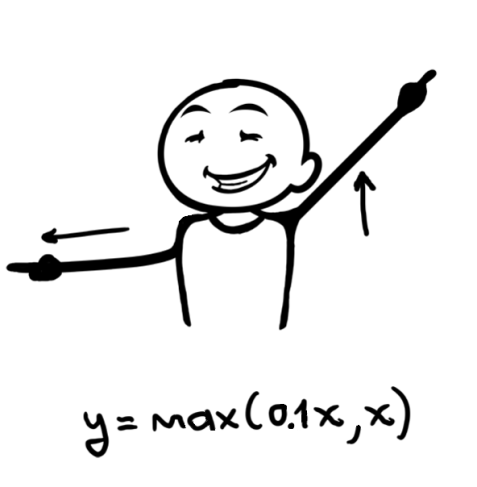

n summary, nn.LeakyReLU(0.2) is an activation function used to introduce non-linearity into a neural network. It is a variant of ReLU that allows a small, non-zero gradient for negative inputs, controlled by the specified negative slope parameter (0.2 in this case).


A few tricks used in generator:
* Instead of ReLU, we use **LeakyReLU**, i.e. a ReLU which is not exactly 0 for negative $x$, but rather another linear function with very small slope.
* We use **BatchNorm1D** in order to stabilize training. 1D for Fully Connected Layers: BatchNorm1D is specifically designed for fully connected layers (dense layers). In the context of neural networks, 1D denotes that the normalization is applied along the feature dimension.
* The activation function on last layer is **Tanh**, so the output is in the range [-1,1].

## Discriminator

Discriminator is a classical image classification network. In our first example, we will also use linear classifier.

The `Discriminator` class is a neural network model designed for binary classification. Its primary purpose is to discriminate between real and generated images.


In [ ]:
# Discriminator Class


## Initialization
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        input = input.view(input.shape[0], -1)
        hidden1 = self.leaky_relu(self.linear1(input))
        hidden2 = self.leaky_relu(self.linear2(hidden1))
        classififed = self.sigmoid(self.linear3(hidden2))
        return classififed

## Loading dataset

We will use MNIST dataset.

## Function Parameters:

- **train_part:** The proportion of the dataset to be used for training. It is a float value between 0 and 1.
- **transform:** An optional transformation to be applied to the dataset.

## Function Behavior:

1. **Dataset Loading:**
   - The MNIST dataset is loaded using `torchvision.datasets.MNIST`. If the dataset is not already present in the specified directory ('.'), it will be downloaded.

2. **Training Set Calculation:**
   - The `train_part` parameter is used to calculate the number of samples to include in the training set (`train_part * len(dataset)`).

3. **Random Splitting:**
   - The dataset is randomly split into training and testing subsets using `torch.utils.data.random_split`. The lengths of the subsets are determined based on the calculated number of samples for the training set.

4. **Output:**
   - The resulting training and testing datasets are returned as a tuple.

## Usage Example:

```python
# Example: Split MNIST dataset with 80% for training
train_data, test_data = mnist(0.8, transform=transforms.ToTensor())


In [ ]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

# Example: Splitting MNIST Dataset with 80% for Training

In this example, the `mnist` function is used to split the MNIST dataset into training and testing subsets. The training set will contain 80% of the total dataset, and the `transforms.ToTensor()` transformation will be applied to convert images to PyTorch tensors.

```python
# Example Code
train_data, test_data = mnist(0.8, transform=transforms.ToTensor())


# Transformation Composition Example

In this example, a composition of transformations is defined using `transforms.Compose` from PyTorch's torchvision library. The composed transformations include converting images to tensors (`transforms.ToTensor()`) and normalizing pixel values with a mean of 0.5 and a standard deviation of 0.5.


In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5)
])

In [ ]:
train_dataset, test_dataset = mnist(train_size, transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 81239372.61it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 107389799.49it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42404067.55it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18585881.72it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# DataLoader Setup for Training

In this example, a `DataLoader` is set up for the training dataset to facilitate the training process. The DataLoader is part of PyTorch's `torch.utils.data` module and is used to efficiently load and iterate over batches of data during training.

```python
# DataLoader Setup
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,          # Training dataset
    drop_last=True,         # Drops the last incomplete batch if the dataset size is not divisible by the batch size
    batch_size=batch_size,  # Batch size for each iteration
    shuffle=True            # Shuffles the data for each epoch
)

# Combine DataLoaders
dataloaders = (train_dataloader, )


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
dataloaders = (train_dataloader, )

## Network training

On each step of the training, we have **two** phases:

* **Generator** training. We generate some random vectors **noise** (training happens in minibatches, so we use 100 vectors at a time), generate **true labels** (vector with shape (bs, 1) with 1.0 values), calculate generator loss between output from **frozen** discriminator with noise as input and true labels.

* **Discriminator** training. We calculate discriminator loss from **two** parts, **first** part is loss between output from discriminator with noise as input and **fake labels** (vector with shape (bs, 1) with 0.0 values), **second** part is loss between output from discriminator with real images as input and true labels (vector with shape (bs, 1) with 1.0 values). **Result loss** is (first_part_loss + second_part_loss) / 2.

In [ ]:
def plotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100))).to(device)
    imgs = generator(noise).detach().cpu()
    fig, ax = plt.subplots(1, n)
    for i, im in enumerate(imgs):
        ax[i].imshow(im[0])
    plt.show()

# GAN Training Function

The provided function `train_gan` is designed for training a Generative Adversarial Network (GAN) using PyTorch. It takes input data loaders, GAN models, optimizers, loss function, training epochs, and other parameters to perform the training process.

## Parameters:

- **dataloaders:** Tuple containing data loaders (e.g., train, test).
- **models:** Tuple containing GAN models (e.g., generator, discriminator).
- **optimizers:** Tuple containing optimizers for generator and discriminator.
- **loss_fn:** Loss function used for training.
- **epochs:** Number of training epochs.
- **plot_every:** Interval for plotting generated samples during training.
- **device:** Device on which to perform the training (e.g., 'cuda:0' or 'cpu').

## Training Loop:

1. The training loop iterates over the specified number of epochs.
2. The generator and discriminator are set to training mode.
3. Loss variables for the generator and discriminator are initialized.
4. For each batch in the training data loader:
   - Real images are obtained and moved to the specified device.
   - The generator is updated using a backpropagation step.
   - Discriminator predictions for generated images are obtained.
   - Discriminator loss for real and fake samples is calculated and backpropagated for the discriminator.
   - Loss values are accumulated for monitoring.

5. After each epoch, the average generator and discriminator losses are calculated.
6. Optionally, generated samples are plotted at specified intervals.
7. Progress is displayed using tqdm with updated loss values.

## Note:

- The function assumes that the generator and discriminator models are compatible with the provided loss function.

- The `plotn` function (not provided) is called to plot generated samples during training.

- Make sure the input models, optimizers, and loss function are properly initialized before calling this function.

This function provides a basic GAN training loop and can be extended or modified based on specific requirements.


In [ ]:
def train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]

    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]

    for epoch in tqdm_iter:
        gen.train()
        disc.train()

        train_gen_loss = 0.0
        train_disc_loss = 0.0

        test_gen_loss = 0.0
        test_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)

            disc.eval()
            gen.zero_grad()

            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)

            generated = gen(noise)
            disc_preds = disc(generated)

            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.train()
            disc.zero_grad()

            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()

        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            plotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

# GAN Setup

In this section, the components required for training a Generative Adversarial Network (GAN) are set up. The following elements are created and configured:

1. **Generator and Discriminator Models:**
   - Instances of the `Generator` and `Discriminator` classes are created.
   - These models are moved to the specified device (e.g., 'cuda:0').

```python
generator = Generator().to(device)
discriminator = Discriminator().to(device)


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers:
# Adam optimizers are instantiated for both the generator and discriminator.
# Learning rate, weight decay, and betas parameters are configured.

optimizer_generator = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

models = (generator, discriminator)
optimizers = (optimizer_generator, optimizer_discriminator)

  0%|          | 0/100 [00:00<?, ?it/s]

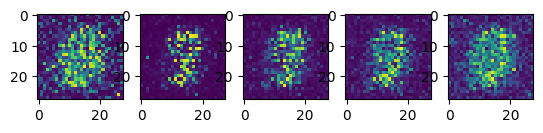

 10%|█         | 10/100 [02:28<21:08, 14.09s/it, generator loss:=0.997, discriminator loss:=0.571]

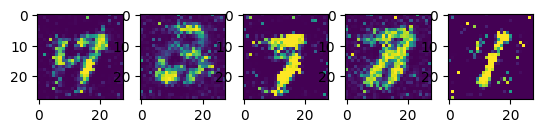

 20%|██        | 20/100 [04:45<18:23, 13.79s/it, generator loss:=0.909, discriminator loss:=0.609]

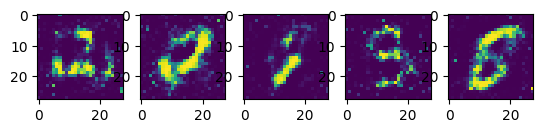

 30%|███       | 30/100 [07:00<15:35, 13.36s/it, generator loss:=0.871, discriminator loss:=0.625]

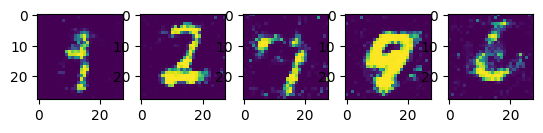

 40%|████      | 40/100 [09:14<13:31, 13.53s/it, generator loss:=0.849, discriminator loss:=0.635]

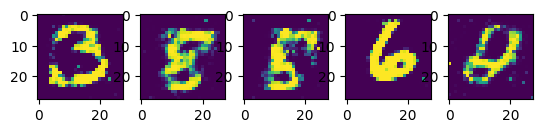

 50%|█████     | 50/100 [11:28<11:08, 13.37s/it, generator loss:=0.836, discriminator loss:=0.64]

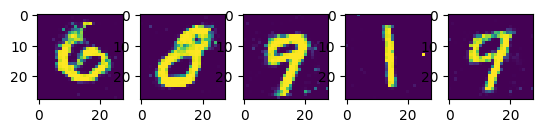

 60%|██████    | 60/100 [13:39<08:42, 13.07s/it, generator loss:=0.836, discriminator loss:=0.64]

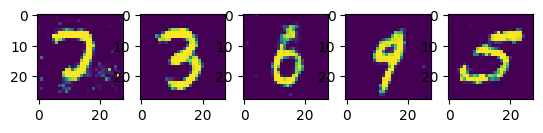

 70%|███████   | 70/100 [15:52<06:29, 12.98s/it, generator loss:=0.841, discriminator loss:=0.638]

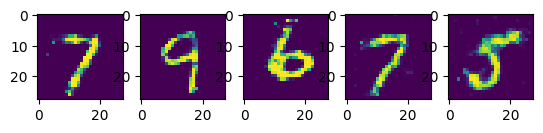

 80%|████████  | 80/100 [18:05<04:25, 13.29s/it, generator loss:=0.845, discriminator loss:=0.635]

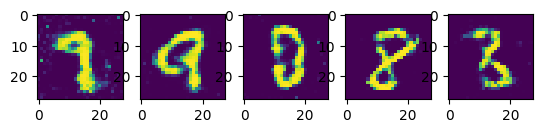

 90%|█████████ | 90/100 [20:17<02:12, 13.30s/it, generator loss:=0.848, discriminator loss:=0.633]

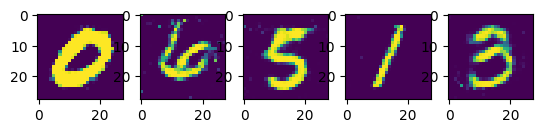

 99%|█████████▉| 99/100 [22:18<00:13, 13.28s/it, generator loss:=0.851, discriminator loss:=0.633]

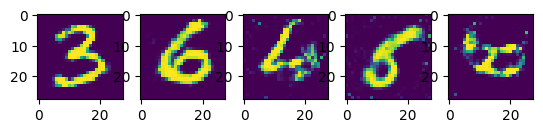

100%|██████████| 100/100 [22:32<00:00, 13.52s/it, generator loss:=0.856, discriminator loss:=0.633]


In [ ]:
train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device)

## DCGAN

**Deep Convolutional GAN** is pretty obvious idea of using convolutional layers for generator and discriminator. The main difference here is using **Conv2DTranspose** layer in the generator.

<img src="images/dcgan_generator.png" width="60%"/>

> Image from [this tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [ ]:
# DCGenerator Class
class DCGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        # Transposed convolutional layers with batch normalization and activation functions
        self.conv1 = nn.ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)

        # Activation functions
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, input):
        # Forward pass through the layers
        hidden1 = self.relu(self.bn1(self.conv1(input)))
        hidden2 = self.relu(self.bn2(self.conv2(hidden1)))
        hidden3 = self.relu(self.bn3(self.conv3(hidden2)))

        # Output layer with Tanh activation, reshaped to image dimensions (28x28)
        generated = self.tanh(self.conv4(hidden3)).view(input.shape[0], 1, 28, 28)
        return generated


In [ ]:
# DCDiscriminator Class
class DCDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers with batch normalization, leaky ReLU activation, and sigmoid activation
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

        # Activation functions
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        # Forward pass through the layers
        hidden1 = self.leaky_relu(self.conv1(input))
        hidden2 = self.leaky_relu(self.bn2(self.conv2(hidden1)))
        hidden3 = self.leaky_relu(self.bn3(self.conv3(hidden2)))

        # Output layer with sigmoid activation, reshaped for binary classification
        classified = self.sigmoid(self.conv4(hidden3)).view(input.shape[0], -1)
        return classified


Weights initialization from [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) paper.

In [ ]:
# weights_init Function
def weights_init(model):
    """
    Initialize the weights of a neural network model.

    Parameters:
    - model (nn.Module): The neural network model.

    Behavior:
    - Initializes weights of Convolutional layers with normal distribution (mean=0, std=0.02).
    - Initializes weights of Batch Normalization layers with normal distribution (mean=1, std=0.02).
    - Initializes biases of Batch Normalization layers with constant value 0.
    """

    # Iterate through all modules in the model
    for m in model.modules():
        classname = m.__class__.__name__

        # Initialize weights for Convolutional layers
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)

        # Initialize weights and biases for Batch Normalization layers
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)


In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
])

In [ ]:
train_dataset, test_dataset = mnist(train_size, transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
dataloaders = (train_dataloader, )

In [ ]:
generator = DCGenerator().to(device)
generator.apply(weights_init)
discriminator = DCDiscriminator().to(device)
discriminator.apply(weights_init)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

models = (generator, discriminator)
optimizers = (optimizer_generator, optimizer_discriminator)

In [ ]:
def dcplotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100, 1, 1))).to(device)
    imgs = generator(noise).detach().cpu()
    fig, ax = plt.subplots(1, n)
    for i, im in enumerate(imgs):
        ax[i].imshow(im[0])
    plt.show()

In [ ]:
def train_dcgan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]

    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]

    gen.train()
    disc.train()

    for epoch in tqdm_iter:
        train_gen_loss = 0.0
        train_disc_loss = 0.0

        test_gen_loss = 0.0
        test_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)
            imgs = 2.0 * imgs - 1.0

            gen.zero_grad()

            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100, 1, 1))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)

            generated = gen(noise)
            disc_preds = disc(generated)

            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.zero_grad()

            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()

        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            dcplotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

  0%|          | 0/50 [00:00<?, ?it/s]

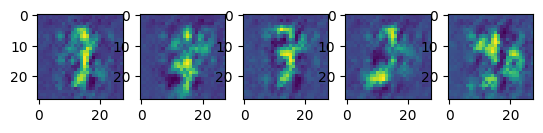

 10%|█         | 5/50 [01:14<10:58, 14.63s/it, generator loss:=2.3, discriminator loss:=0.26]

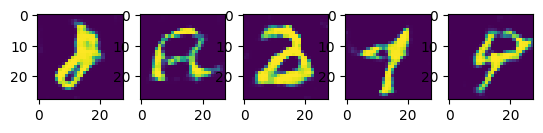

 20%|██        | 10/50 [02:26<09:37, 14.43s/it, generator loss:=2.05, discriminator loss:=0.284]

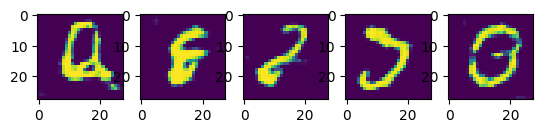

 30%|███       | 15/50 [03:39<08:25, 14.45s/it, generator loss:=2.07, discriminator loss:=0.273]

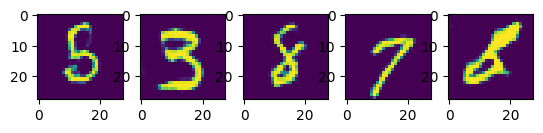

 40%|████      | 20/50 [04:51<07:15, 14.53s/it, generator loss:=2.11, discriminator loss:=0.273]

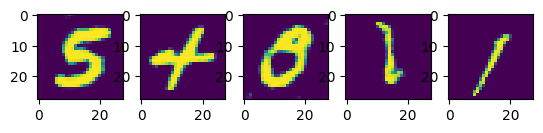

 50%|█████     | 25/50 [06:04<06:01, 14.47s/it, generator loss:=2.18, discriminator loss:=0.278]

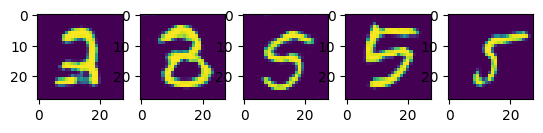

 60%|██████    | 30/50 [07:17<04:49, 14.48s/it, generator loss:=2.33, discriminator loss:=0.233]

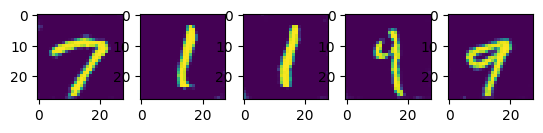

 70%|███████   | 35/50 [08:30<03:37, 14.48s/it, generator loss:=2.31, discriminator loss:=0.262]

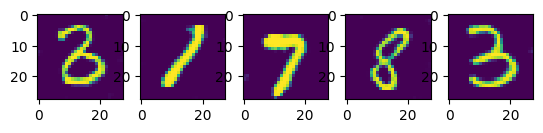

 80%|████████  | 40/50 [09:43<02:25, 14.59s/it, generator loss:=2.48, discriminator loss:=0.222]

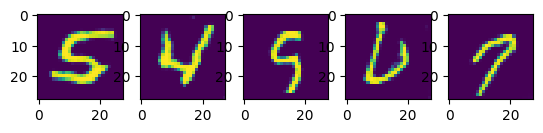

 90%|█████████ | 45/50 [10:55<01:12, 14.46s/it, generator loss:=2.57, discriminator loss:=0.191]

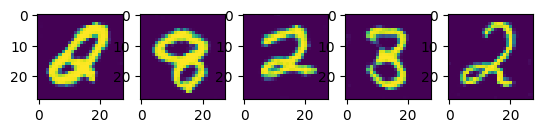

 98%|█████████▊| 49/50 [11:53<00:14, 14.47s/it, generator loss:=2.69, discriminator loss:=0.192]

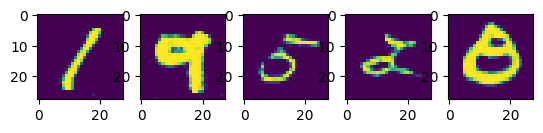

100%|██████████| 50/50 [12:08<00:00, 14.57s/it, generator loss:=2.67, discriminator loss:=0.208]


In [ ]:
train_dcgan(dataloaders, models, optimizers, loss_fn, epochs // 2, plot_every // 2, device)

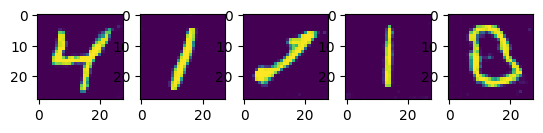

In [ ]:
generator.eval()
dcplotn(5, generator, device)